Load Libraries

In [1]:
!pip install biopython seaborn
%pip install biopython
%pip install seaborn
!pip install -q biopython transformers datasets huggingface_hub accelerate

import os
import zipfile
import torch
import random
import sys

import matplotlib.pyplot as plt
import numpy as np

from Bio import SeqIO, Entrez
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from datasets import Dataset
from itertools import product
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, BertForSequenceClassification, BertTokenizer
from tqdm import tqdm

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# Verify wandb is disabled
print("WANDB_DISABLED:", os.environ.get("WANDB_DISABLED"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
WANDB_DISABLED: true


Seeding

In [2]:
import random
import numpy as np
import torch
from transformers import set_seed


# Set random seeds for reproducibility
SEED = 42

# Python's random module
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# For TensorFlow (if using it)
try:
    import tensorflow as tf
    tf.random.set_seed(SEED)
except ImportError:
    pass

# Hugging Face Transformers
set_seed(SEED)

print("Random seeds set for reproducibility.")


Random seeds set for reproducibility.


Clone DNABERT6 Repository

In [3]:
# Install necessary libraries
!pip install torch torchvision transformers datasets gdown

# Clone the DNA-BERT repository
!git clone https://github.com/jerryji1993/DNABERT.git


Cloning into 'DNABERT'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (778/778), done.
remote: Compressing objects: 100% (348/348), done.
remote: Total 778 (delta 420), reused 721 (delta 407), pack-reused 0 (from 0)
Receiving objects: 100% (778/778), 11.66 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (420/420), done.


NB!!! upload zip file (6-new-12w-0.zip) before continuing else code won't run




In [4]:
# Path to the uploaded zip file
uploaded_zip_path = '/content/6-new-12w-0.zip'

# Define the directory for extraction
PRETRAINED_DIR = "/content/DNABERT/pretrained/dna6"
os.makedirs(PRETRAINED_DIR, exist_ok=True)  # Attempt to create the directory

# Extract the zip file
try:
    with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
        zip_ref.extractall(PRETRAINED_DIR)
    print(f"Extracted DNA-BERT files to: {PRETRAINED_DIR}")
except PermissionError as e:
    print(f"Permission denied: {e}. Check your permissions for '/content'.")
except Exception as e:
    print(f"An error occurred: {e}")


Extracted DNA-BERT files to: /content/DNABERT/pretrained/dna6


Clone Seminar Repository

In [5]:
directory = "seminar-dlmb-2024-winter-public"

if os.path.exists(directory) and os.listdir(directory):
    print(f"Directory {directory} exists and is non-empty.")
else:
    print(f"Directory {directory} does not exist or is empty.")
    !!git clone https://github.com/hzi-bifo/seminar-dlmb-2024-winter-public.git

Directory seminar-dlmb-2024-winter-public does not exist or is empty.


In [6]:
# Define the working device
device = torch.device("cuda")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA A100-SXM4-40GB is available.


Create Datasets

In [7]:
# Paths
base_path = "seminar-dlmb-2024-winter-public/"
data_path = "seminar-dlmb-2024-winter-public/data/ds1"

sys.path.append('seminar-dlmb-2024-winter-public/src/')
from amr.amr_utility import load_gene_data, create_gene_datasets

# Create datasets
create_gene_datasets(base_path, data_path)

# Load dataset
ds = load_gene_data(data_path, "Staphylococcus_aureus_cefoxitin", "pbp4")

sequences_train = [x[1] for x in ds["train"]]
labels_train = [x[2] for x in ds["train"]]

sequences_test = [x[1] for x in ds["test"]]
labels_test = [x[2] for x in ds["test"]]

sequences = sequences_train + sequences_test
labels = labels_train + labels_test

# Separate data by classes
class_0 = [(seq, label) for seq, label in zip(sequences, labels) if label == 0]
class_1 = [(seq, label) for seq, label in zip(sequences, labels) if label == 1]

random.shuffle(class_0)
random.shuffle(class_1)

test_data = class_0[:7] + class_1[:7]
leftover_class_0 = class_0[7:]
leftover_class_1 = class_1[7:]

val_data = leftover_class_0[:7] + leftover_class_1[:7]
leftover_class_0 = leftover_class_0[7:]
leftover_class_1 = leftover_class_1[7:]

train_data = leftover_class_0 + leftover_class_1

random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Split train, val, and test data into sequences and labels
sequences_train = [seq for seq, label in train_data]
labels_train = [label for seq, label in train_data]

sequences_val = [seq for seq, label in val_data]
labels_val = [label for seq, label in val_data]

sequences_test = [seq for seq, label in test_data]
labels_test = [label for seq, label in test_data]


print("Test Data:", labels_test)


Test Data: [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]


In [8]:
%cd /content/DNABERT/pretrained/

!ls -l /content/DNABERT/pretrained/

!mv /content/DNABERT/pretrained/dna6/6-new-12w-0/* /content/DNABERT/pretrained/dna6/

!rm -rf /content/DNABERT/pretrained/dna6/6-new-12w-0

!ls -l /content/DNABERT/pretrained/dna6

/content/DNABERT/pretrained
total 4
drwxr-xr-x 3 root root 4096 Jan  9 05:55 dna6
total 350828
-rw-r--r-- 1 root root      1110 Jan  9 05:55 config.json
-rw-r--r-- 1 root root 359199902 Jan  9 05:55 pytorch_model.bin
-rw-r--r-- 1 root root       112 Jan  9 05:55 special_tokens_map.json
-rw-r--r-- 1 root root        40 Jan  9 05:55 tokenizer_config.json
-rw-r--r-- 1 root root     28703 Jan  9 05:55 vocab.txt


In [9]:
from itertools import product

class SEQTokenizer_Kmers:
    """Custom tokenizer for DNA sequences with k-mers."""

    def __init__(self, k):
        """
        Initialize the tokenizer.

        Args:
            k (int): Length of each k-mer.
        """
        self.k = k

        # Create vocabulary of all possible k-mers
        self.vocab = [''.join(kmer) for kmer in product('ATCG', repeat=k)]
        self.token_to_id = {token: i for i, token in enumerate(self.vocab)}

    def encode(self, sequence):
        """
        Tokenize and encode a DNA sequence into k-mers.

        Args:
            sequence (str): DNA sequence to encode.

        Returns:
            list: A list of token IDs for the k-mers.
        """
        if len(sequence) < self.k:
            raise ValueError(f"Sequence length must be at least {self.k} to generate k-mers.")

        # Generate k-mers from the sequence
        kmers = [sequence[i:i+self.k] for i in range(len(sequence) - self.k + 1)]

        # Map k-mers to their token IDs
        return [self.token_to_id[kmer] for kmer in kmers if kmer in self.token_to_id]
tokenizer = SEQTokenizer_Kmers(k=6)

# Tokenize the datasets using the encode method
train_tokenized = [tokenizer.encode(seq) for seq in sequences_train]
test_tokenized = [tokenizer.encode(seq) for seq in sequences_test]
val_tokenized = [tokenizer.encode(seq) for seq in sequences_val]



In [10]:
class SequenceProcessor:
    """Processes encoded sequences by adding padding or splitting into chunks."""

    def __init__(self, max_length=512, padding_value=0):
        """
        Initialize the processor.

        Args:
            max_length (int): Maximum length for a sequence or chunk.
            padding_value (int): Value to use for padding shorter sequences.
        """
        self.max_length = max_length
        self.padding_value = padding_value

    def process(self, encoded_sequence):
        """
        Process an encoded sequence by adding padding or splitting.

        Args:
            encoded_sequence (list): Encoded sequence of token IDs.

        Returns:
            list: A list of processed sequences (each of length max_length).
        """
        if len(encoded_sequence) <= self.max_length:
            # Add padding if sequence is shorter than max_length
            return [self._add_padding(encoded_sequence)]
        else:
            # Split into chunks if sequence is longer than max_length
            return self._split_into_chunks(encoded_sequence)

    def _add_padding(self, sequence):
        """
        Add padding to a sequence to make it max_length.

        Args:
            sequence (list): Encoded sequence of token IDs.

        Returns:
            list: Padded sequence of length max_length.
        """
        return sequence + [self.padding_value] * (self.max_length - len(sequence))

    def _split_into_chunks(self, sequence):
        """
        Split a long sequence into overlapping chunks of max_length.

        Args:
            sequence (list): Encoded sequence of token IDs.

        Returns:
            list: A list of chunks (each of length max_length).
        """
        step = self.max_length // 2  # 50% overlap
        return [
            sequence[i:i + self.max_length]
            for i in range(0, len(sequence), step)
            if len(sequence[i:i + self.max_length]) == self.max_length
        ]

processor = SequenceProcessor(max_length=512, padding_value=-1)


In [11]:
import pandas as pd

class SequenceDataset:
    """Creates a dataset with sequence IDs, sequences, encoded sequences, processed sequences, and class labels."""

    def __init__(self, sequences, labels, tokenizer, processor):
        """
        Initialize the dataset.

        Args:
            sequences (list): List of DNA sequences.
            labels (list): List of class labels corresponding to the sequences.
            tokenizer (SEQTokenizer_Kmers): Tokenizer to encode sequences.
            processor (SequenceProcessor): Processor to pad or split sequences.
        """
        if len(sequences) != len(labels):
            raise ValueError("The number of sequences and labels must match.")

        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.processor = processor

    def create_dataset(self):
        """
        Create the dataset.

        Returns:
            pd.DataFrame: A dataset containing sequence ID, sequence, encoded sequence,
                          processed sequence, and class label.
        """
        dataset = []
        for seq_id, (sequence, label) in enumerate(zip(self.sequences, self.labels)):
            # Tokenize and encode the sequence
            encoded_sequence = self.tokenizer.encode(sequence)

            # Process the encoded sequence
            processed_sequence = self.processor.process(encoded_sequence)

            # Add each chunk to the dataset with the same sequence ID and class
            for chunk in processed_sequence:
                dataset.append({
                    "sequence_id": seq_id,
                    "sequence": sequence,
                    "encoded_sequence": encoded_sequence,
                    "processed_sequence": chunk,
                    "class": label
                })

        return pd.DataFrame(dataset)

# Create the dataset
create_test= SequenceDataset(sequences_test, labels_test, tokenizer, processor)
processed_test = create_test.create_dataset()

create_train= SequenceDataset(sequences_train, labels_train, tokenizer, processor)
processed_train = create_train.create_dataset()

create_val= SequenceDataset(sequences_val, labels_val, tokenizer, processor)
processed_val = create_val.create_dataset()

# Print the class column
print("\nClass Column:")
print(processed_test["sequence_id"])


Class Column:
0      0
1      0
2      0
3      0
4      1
5      1
6      1
7      1
8      2
9      2
10     2
11     2
12     3
13     3
14     3
15     3
16     4
17     4
18     4
19     4
20     5
21     5
22     5
23     5
24     6
25     6
26     6
27     6
28     7
29     7
30     7
31     7
32     8
33     8
34     8
35     8
36     9
37     9
38     9
39     9
40    10
41    10
42    10
43    10
44    11
45    11
46    11
47    11
48    12
49    12
50    12
51    12
52    13
53    13
54    13
55    13
Name: sequence_id, dtype: int64


In [12]:
# Tokenize the datasets using the encode method
#train_tokenized = processed_train["processed_sequence"]
#test_tokenized = processed_test["processed_sequence"]
#val_tokenized = processed_val["processed_sequence"]

# Convert the tokenized data into Hugging Face Dataset objects
train_dataset = Dataset.from_dict({"input_ids": processed_train["processed_sequence"]})
test_dataset = Dataset.from_dict({"input_ids": processed_test["processed_sequence"]})
val_dataset = Dataset.from_dict({"input_ids": processed_val["processed_sequence"]})

# Add the labels to each dataset
train_dataset = train_dataset.add_column("labels", processed_train["class"])
test_dataset = test_dataset.add_column("labels", processed_test["class"])
val_dataset = val_dataset.add_column("labels", processed_val["class"])

# Print the first training example
print(train_dataset[0])

{'input_ids': [1792, 3072, 1, 5, 21, 84, 336, 1345, 1284, 1041, 70, 281, 1124, 401, 1605, 2324, 1105, 326, 1304, 1121, 390, 1560, 2145, 389, 1557, 2133, 340, 1361, 1351, 1309, 1141, 469, 1876, 3408, 1346, 1288, 1057, 133, 532, 2128, 323, 1293, 1076, 209, 837, 3348, 1105, 327, 1308, 1138, 456, 1826, 3210, 552, 2209, 644, 2577, 2119, 286, 1144, 482, 1928, 3616, 2179, 526, 2105, 231, 926, 3705, 2532, 1936, 3650, 2312, 1059, 141, 567, 2268, 882, 3531, 1837, 3252, 720, 2882, 3338, 1066, 170, 681, 2727, 2717, 2676, 2514, 1864, 3360, 1155, 526, 2104, 227, 910, 3640, 2272, 896, 3585, 2054, 24, 96, 385, 1540, 2065, 71, 287, 1149, 501, 2004, 3921, 3399, 1310, 1144, 483, 1935, 3645, 2293, 981, 3927, 3421, 1398, 1499, 1903, 3518, 1785, 3047, 3998, 3704, 2529, 1924, 3602, 2123, 300, 1200, 706, 2826, 3115, 172, 690, 2763, 2860, 3251, 717, 2871, 3294, 889, 3559, 1949, 3701, 2516, 1872, 3393, 1287, 1053, 117, 468, 1875, 3405, 1334, 1240, 864, 3456, 1538, 2057, 39, 159, 636, 2546, 1992, 3872, 3201, 517

In [13]:
# Print the sequence lenghts of all available sequences
all_sequences = sequences_train + sequences_test + sequences_val

seq_lengths = [len(seq) for seq in all_sequences]
print(seq_lengths)

[1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296]


In [14]:
# Get labels from the training dataset
labels = train_dataset["labels"]

# Compute class weights so classes seem balanced
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights_tensor)

Class Weights: tensor([2.3462, 0.6354])


In [31]:
import torch
import random
import numpy as np
from transformers import BertForSequenceClassification

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class WeightedModel(torch.nn.Module):
    def __init__(self, model_name, class_weights, seed=42):
        super().__init__()
        set_seed(seed)  # Ensure seed is set before initializing model weights
        self.model = BertForSequenceClassification.from_pretrained(
            model_name, num_labels=len(class_weights)
        )
        self.loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

set_seed(SEED)  # Set the seed before any model initialization
model = WeightedModel("/content/DNABERT/pretrained/dna6", class_weights_tensor, seed=SEED)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/DNABERT/pretrained/dna6 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
def create_kmer_vocab(k):
    # Generate all possible k-mers using the alphabet "A", "T", "C", "G"
    alphabet = "ATCG"
    kmers = [''.join(p) for p in product(alphabet, repeat=k)]
    return kmers

# Set k-mer size
k = 6

# Generate vocabulary
vocab = create_kmer_vocab(k)

# Save the vocabulary to a file
vocab_file_path = "/content/DNABERT/pretrained/dna6/vocab.txt"
with open(vocab_file_path, "w") as f:
    f.write("\n".join(vocab))

print(f"Vocabulary file created at: {vocab_file_path}")

# Load the tokenizer with the new vocabulary file
tokenizer = BertTokenizer.from_pretrained(
    "/content/DNABERT/pretrained/dna6",
    vocab_file="/content/DNABERT/pretrained/dna6/vocab.txt"
)

Vocabulary file created at: /content/DNABERT/pretrained/dna6/vocab.txt


In [33]:
OUTPUT_PATH = "/content/DNABERT/output"  # Define a permanent output directory

training_args = TrainingArguments(
    output_dir=OUTPUT_PATH,  # Save outputs to a permanent directory
    evaluation_strategy="epoch",  # Evaluate at the end of every epoch
    logging_strategy="epoch",     # Log training/validation loss every epoch
    save_strategy="epoch",        # Save checkpoints at the end of each epoch
    save_total_limit=1,           # Keep the last checkpoint
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 16,
    num_train_epochs=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_dir=f"{OUTPUT_PATH}/logs",
)

os.makedirs(OUTPUT_PATH, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [34]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

<ipython-input-34-373c322edf99>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [35]:
# Train the model
print("Starting training...")
trainer.train()

# Evaluate the model
print("Evaluating model on test set...")
results = trainer.evaluate(test_dataset)
print("Test Results:", results)

Starting training...


Epoch,Training Loss,Validation Loss
1,0.512600,0.754380
2,0.429300,0.735942
3,0.407000,0.731409
4,0.417200,0.674627
5,0.422300,0.560935
6,0.417400,0.752565
7,0.370300,0.521443
8,0.321200,0.741030
9,0.320400,0.524303
10,0.313600,0.502117


Evaluating model on test set...


Test Results: {'eval_loss': 0.6500102877616882, 'eval_runtime': 0.3979, 'eval_samples_per_second': 140.734, 'eval_steps_per_second': 10.052, 'epoch': 50.0}


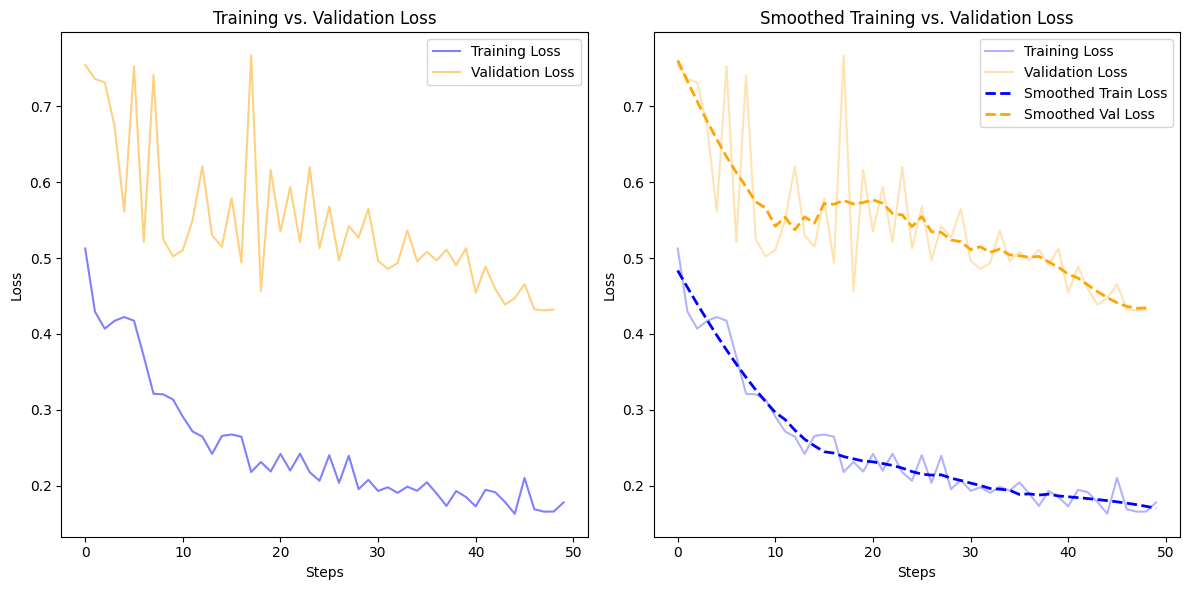

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Extract training history
history = trainer.state.log_history

# Extract training and validation losses
train_loss = [log["loss"] for log in history if "loss" in log]
val_loss = [log["eval_loss"] for log in history if "eval_loss" in log]

# Use only the first 49 validation points for smoothing
val_loss_subset = val_loss[:49]

# Apply Savitzky-Golay filter for smoother curves
train_smoothed = savgol_filter(train_loss, window_length=21, polyorder=3)  # Smoothing training loss
val_smoothed = savgol_filter(val_loss_subset, window_length=15, polyorder=3)  # Smoothing validation loss

# Steps (x-axis)
train_steps = list(range(len(train_loss)))
val_steps = list(range(len(val_loss_subset)))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Original plot on the left
axes[0].plot(train_loss, label="Training Loss", color="blue", alpha=0.5)
axes[0].plot(val_loss_subset, label="Validation Loss", color="orange", alpha=0.5)
axes[0].set_title("Training vs. Validation Loss")
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot with smoothed curves on the right
axes[1].plot(train_steps, train_loss, label="Training Loss", color="blue", alpha=0.3)
axes[1].plot(val_steps, val_loss_subset, label="Validation Loss", color="orange", alpha=0.3)
axes[1].plot(train_steps, train_smoothed, label="Smoothed Train Loss", color="blue", linestyle="--", linewidth=2)
axes[1].plot(val_steps, val_smoothed, label="Smoothed Val Loss", color="orange", linestyle="--", linewidth=2)
axes[1].set_title("Smoothed Training vs. Validation Loss")
axes[1].set_xlabel("Steps")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


In [37]:
predictions = trainer.predict(test_dataset=test_dataset)
print(predictions.predictions)  # Raw logits

# Get predicted class labels from logits
predicted_classes = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Display the predicted class labels
print("Predicted Classes:", predicted_classes)
print("True Classes:", true_labels)    # True labels

def compute_metrics(true_labels, predicted_classes):
    precision = precision_score(true_labels, predicted_classes, average="weighted")
    recall = recall_score(true_labels, predicted_classes, average="weighted")
    f1 = f1_score(true_labels, predicted_classes, average="weighted")
    accuracy = accuracy_score(true_labels, predicted_classes)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

# Call the function
metrics = compute_metrics(true_labels, predicted_classes)
print(len(predicted_classes))

[[ 3.0852716   0.8725164  -5.2887526 ]
 [ 3.1772592   0.8314396  -5.3548512 ]
 [ 2.9564853   1.4934043  -5.7088    ]
 [ 3.4197197   0.24991034 -4.935544  ]
 [ 0.4403497   4.318654   -5.8524404 ]
 [-0.16199318  4.695738   -5.6451793 ]
 [ 0.43490586  4.274779   -5.8893228 ]
 [-1.2863742   5.067596   -4.5235314 ]
 [-1.7892649   5.2080708  -4.1796346 ]
 [-1.9854839   5.341259   -3.9466534 ]
 [-2.5897224   5.334338   -3.1692355 ]
 [-1.9906497   4.9849515  -3.508557  ]
 [ 0.4403497   4.318654   -5.8524404 ]
 [-0.16199318  4.695738   -5.6451793 ]
 [ 0.43490586  4.274779   -5.8893228 ]
 [-1.2863742   5.067596   -4.5235314 ]
 [-2.3573072   5.2304406  -3.6159964 ]
 [-2.6169155   5.433004   -3.4261203 ]
 [-2.8881004   5.426336   -2.9867325 ]
 [-2.6087856   5.4610815  -3.2869484 ]
 [ 1.7458862   2.984615   -5.484     ]
 [ 2.3884895   2.5595133  -6.137845  ]
 [ 2.0974538   2.402953   -5.858665  ]
 [ 2.925537    1.3877242  -5.3747983 ]
 [ 1.3471727   3.1436572  -5.2832713 ]
 [ 1.9053026   3.1123877 

In [38]:
import pandas as pd
from collections import Counter

class ClassModeDataset:
    """Creates a dataset with the mode of predicted classes for each sequence ID."""

    def __init__(self, sequence_ids, predicted_classes):
        """
        Initialize the dataset.

        Args:
            sequence_ids (list): List of sequence IDs.
            predicted_classes (list): List of predicted classes corresponding to sequence IDs.
        """
        if len(sequence_ids) != len(predicted_classes):
            raise ValueError("The number of sequence IDs must match the number of predicted classes.")

        self.sequence_ids = sequence_ids
        self.predicted_classes = predicted_classes

    def create_dataset(self):
        """
        Create a dataset with the mode of predicted classes for each sequence ID.

        Returns:
            pd.DataFrame: A dataset containing sequence_id and the mode of predicted classes.
        """
        # Create a DataFrame from the input data
        data = pd.DataFrame({
            "sequence_id": self.sequence_ids,
            "predicted_class": self.predicted_classes
        })

        # Group by sequence_id and calculate the mode of predicted_class
        def calculate_mode(classes):
            return Counter(classes).most_common(1)[0][0]

        mode_dataset = (
            data.groupby("sequence_id")["predicted_class"]
            .agg(calculate_mode)
            .reset_index()
        )
        mode_dataset.rename(columns={"predicted_class": "class_mode"}, inplace=True)
        return mode_dataset

class_mode_creator = ClassModeDataset(processed_test["sequence_id"], predicted_classes)
mode_dataset = class_mode_creator.create_dataset()

print("\nDataset with Class Mode:")
print(mode_dataset)


Dataset with Class Mode:
    sequence_id  class_mode
0             0           0
1             1           1
2             2           1
3             3           1
4             4           1
5             5           1
6             6           1
7             7           1
8             8           1
9             9           0
10           10           1
11           11           0
12           12           1
13           13           0


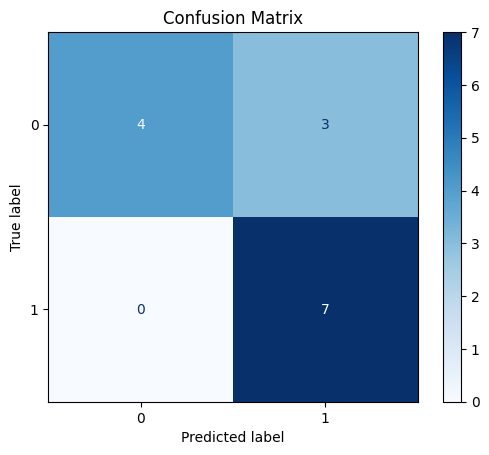

In [39]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(labels_test, mode_dataset["class_mode"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])  # Adjust for more classes
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [40]:
# Generate detailed class-wise metrics
class_report = classification_report(labels_test, mode_dataset["class_mode"], target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.57      0.73         7
     Class 1       0.70      1.00      0.82         7

    accuracy                           0.79        14
   macro avg       0.85      0.79      0.78        14
weighted avg       0.85      0.79      0.78        14



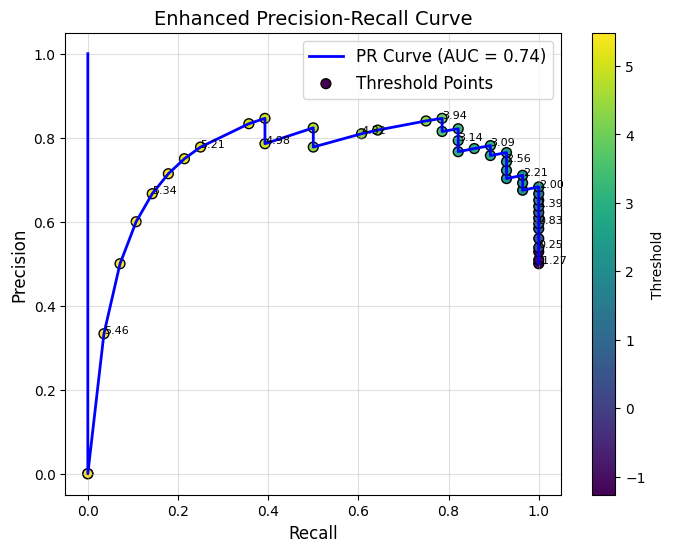

In [41]:
# Assuming binary classification and raw logits
probabilities = predictions.predictions[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)

# Calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='blue', lw=2)

# Highlight threshold points with a larger marker size
plt.scatter(recall[:-1], precision[:-1], c=thresholds, cmap='viridis', s=50, edgecolor='k', label='Threshold Points')

# Annotate thresholds for clarity (every 3rd point)
for i in range(0, len(thresholds), 3):
    plt.text(recall[i], precision[i], f'{thresholds[i]:.2f}', fontsize=8, color='black')

# Enhancements
plt.colorbar(label='Threshold')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Enhanced Precision-Recall Curve', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=12)
plt.show()


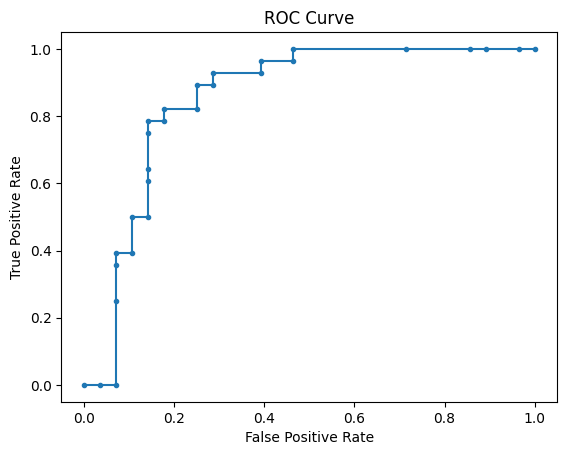

ROC AUC: 0.8546


In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilities for the positive class
probabilities = predictions.predictions[:, 1]  # Adjust for positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)

# Plot ROC curve
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute ROC AUC
roc_auc = roc_auc_score(true_labels, probabilities)
print(f"ROC AUC: {roc_auc:.4f}")

In [ ]:
# Analyze class distribution
unique, counts = np.unique(true_labels, return_counts=True)
print("Class Distribution:", dict(zip(unique, counts)))